# Feasibility UQ

Take the generic DEMO solution, turned into an input file. Remove f-values at iteration vars, and replace their equality constraints with inequalities. Run PROCESS once-through with uncertain inputs, and the QoI as the value of constraints, i.e. the feasibility.

In [1]:
import easyvvuq as uq
import chaospy as cp
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Campaign to capture feasibility

Using the epistemic uncertain inputs for the entire code, capture the distribution of constraint residuals.

To start with, make just 2 inputs uncertain (for running locally).

In [5]:
# Define campaign
WORK_DIR = "campaigns"
Path("campaigns").mkdir(exist_ok=True)
campaign = uq.Campaign(name="model_inputs", work_dir=WORK_DIR)

# Define parameter space
# Uncertainties from Alex's SA paper

params = {
    "fgwped": {
        "type": "float",
        "min": 1.1,
        "max": 1.3,
        "default": 1.1,
    },  # check: not sure if this is right var
    "hfact": {"type": "float", "min": 1.0, "max": 1.2, "default": 1.1},
    "coreradius": {"type": "float", "min": 0.45, "max": 0.75, "default": 0.75},
    "fimp_2": {"type": "float", "min": 0.085, "max": 0.115, "default": 0.1},  # check
    "fimp_14": {
        "type": "float",
        "min": 1.0e-5,
        "max": 1.0e-4,
        "default": 5e-5,
    },  # check
    "psepbqarmax": {"type": "float", "min": 8.7, "max": 9.7, "default": 9.2},
    "flhthresh": {"type": "float", "min": 0.85, "max": 1.15, "default": 1.15},  # check
    "bscfmax": {"type": "float", "min": 0.95, "max": 1.05, "default": 0.99},
    "peakfactrad": {"type": "float", "min": 2.0, "max": 3.5, "default": 3.33},
    "kappa": {"type": "float", "min": 1.8, "max": 1.9, "default": 1.8},  # check default
    "etaech": {"type": "float", "min": 0.3, "max": 0.5, "default": 0.4},
    "feffcd": {"type": "float", "min": 0.5, "max": 5.0, "default": 1.0},
    "etath": {"type": "float", "min": 0.36, "max": 0.4, "default": 0.375},
    "etaiso": {"type": "float", "min": 0.75, "max": 0.95, "default": 0.9},
    "boundl_18": {
        "type": "float",
        "min": 3.25,
        "max": 3.75,
        "default": 3.5,
    },  # q^95_min
    "pinjalw": {"type": "float", "min": 51.0, "max": 61.0, "default": 51.0},
    "alstroh": {"type": "float", "min": 6.0e8, "max": 7.2e8, "default": 6.6e8},
    "sig_tf_wp_max": {
        "type": "float",
        "min": 5.2e8,
        "max": 6.4e8,
        "default": 5.8e8,
    },  # winding pack, or casing?
    "aspect": {"type": "float", "min": 3.0, "max": 3.2, "default": 3.1},
    "boundu_2": {
        "type": "float",
        "min": 11.0,
        "max": 12.0,
        "default": 11.5,
    },  # B_T^max: check default
    "triang": {"type": "float", "min": 0.4, "max": 0.6, "default": 0.5},
    "out_file": {"type": "string", "default": "out.csv"},
}

# QoIs
# Violated constraint residuals
qois = [
    "vio_constr_res",
]

# Create encoder and decoder
encoder = uq.encoders.GenericEncoder(
    template_fname="demo_sol_no_f_IN.template", target_filename="IN.DAT"
)
decoder = uq.decoders.JSONDecoder(
    target_filename="constraints.json", output_columns=qois
)

cmd = "process -i IN.DAT"
actions = uq.actions.local_execute(encoder, cmd, decoder)

# Add the app
campaign.add_app(name="feasibility", params=params, actions=actions)

# Create PCE sampler
vary = {
    "aspect": cp.Uniform(3.0, 3.2),
    "boundu_2": cp.Uniform(11.0, 12.0),
    "triang": cp.Uniform(0.4, 0.6),
    "alstroh": cp.Uniform(6.0e8, 7.2e8),
    "pinjalw": cp.Uniform(51.0, 61.0),
}
pce_sampler = uq.sampling.PCESampler(vary=vary, polynomial_order=3)

# Add pce_sampler to campaign
campaign.set_sampler(pce_sampler)
print(f"Number of samples = {pce_sampler.n_samples}", flush=True)

# Draw samples, execute and collate
# campaign.execute().collate(progress_bar=True)
# samples = campaign.get_collation_result()

Number of samples = 256


In [29]:
samples

,run_id,iteration,aspect,boundu_2,triang,fgwped,hfact,coreradius,fimp_2,fimp_14,...,etaech,feffcd,etath,etaiso,boundl_18,pinjalw,alstroh,sig_tf_wp_max,out_file,vio_constr_res
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,1,0,3.013886,11.069432,0.413886,1.1,1.1,0.75,0.1,0.00005,...,0.4,1.0,0.375,0.9,3.5,51.0,660000000.0,580000000.0,out.csv,0.094163
1,2,0,3.013886,11.069432,0.466002,1.1,1.1,0.75,0.1,0.00005,...,0.4,1.0,0.375,0.9,3.5,51.0,660000000.0,580000000.0,out.csv,0.099185
2,3,0,3.013886,11.069432,0.533998,1.1,1.1,0.75,0.1,0.00005,...,0.4,1.0,0.375,0.9,3.5,51.0,660000000.0,580000000.0,out.csv,0.106504
3,4,0,3.013886,11.069432,0.586114,1.1,1.1,0.75,0.1,0.00005,...,0.4,1.0,0.375,0.9,3.5,51.0,660000000.0,580000000.0,out.csv,0.113543
4,5,0,3.013886,11.330009,0.413886,1.1,1.1,0.75,0.1,0.00005,...,0.4,1.0,0.375,0.9,3.5,51.0,660000000.0,580000000.0,out.csv,0.094163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,60,0,3.186114,11.669991,0.586114,1.1,1.1,0.75,0.1,0.00005,...,0.4,1.0,0.375,0.9,3.5,51.0,660000000.0,580000000.0,out.csv,0.121341
60,61,0,3.186114,11.930568,0.413886,1.1,1.1,0.75,0.1,0.00005,...,0.4,1.0,0.375,0.9,3.5,51.0,660000000.0,580000000.0,out.csv,0.101830
61,62,0,3.186114,11.930568,0.466002,1.1,1.1,0.75,0.1,0.00005,...,0.4,1.0,0.375,0.9,3.5,51.0,660000000.0,580000000.0,out.csv,0.107210


## Plot some samples

The most basic analysis.

Text(0.5, 1.0, 'Variability in vio_constr_res against aspect ratio')

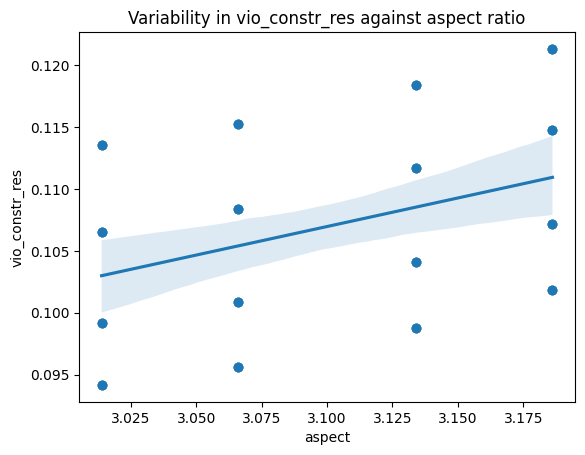

In [30]:
# Plot 2 vars from sample against each other
# Input epistemic uncertainty aspect against vio_constr_res
ax = sns.regplot(x=samples["aspect"], y=samples["vio_constr_res"])
ax.set_xlabel("aspect")
ax.set_ylabel("vio_constr_res")
ax.set_title("Variability in vio_constr_res against aspect ratio")

## Analysis

Analyse vio_constr_residuals, the violated constraint residuals.

### KDE for `vio_constr_res` from EasyVVUQ (plotted with seaborn)

Text(0, 0.5, 'Probability density')

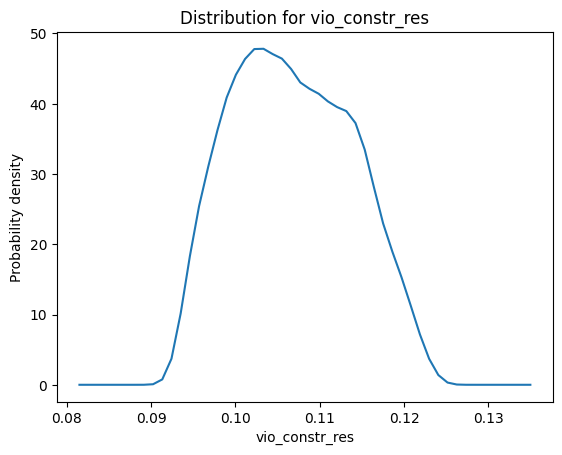

In [31]:
# Try to analyse all outputs variables: produces a linalg error
# results = campaign.analyse(qoi_cols=palph2_inputs)

# Analyse a single output variable, vio_constr_res
results = campaign.analyse(qoi_cols=["vio_constr_res"])

# Get its distribution
dist = results.get_distribution(qoi="vio_constr_res")

# Locations for density function to be evaluated
# (This is taken from easyvvuq's fusion tutorial)
x = np.linspace(dist.lower[0], dist.upper[0])
pdf = dist.pdf(x)

# Plot
ax = sns.lineplot(x=x, y=pdf, markers=True)
ax.set_title("Distribution for vio_constr_res")
ax.set_xlabel("vio_constr_res")
ax.set_ylabel("Probability density")
# Again, this is different on each run: something stochastic

PDF for `vio_constr_res`. Appears right from looking at the EasyVVUQ tutorial (fusion Dask).

### KDE using seaborn alone

Seaborn can produce a KDE itself, using the raw sample data.

<Axes: ylabel='Density'>

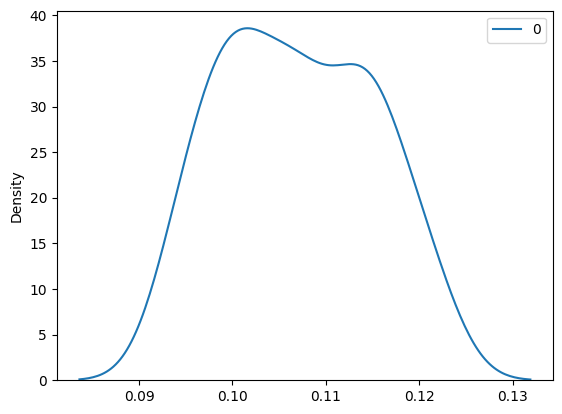

In [32]:
# Try a separate KDE with seaborn only
sns.kdeplot(results.samples["vio_constr_res"])

Seaborn's plot appears smoother and broader. Not sure which to use; inclined to use EasyVVUQ's chaospy distribution (from the EasyVVUQ tutorial).

### Correlation matrix (Correlogram)

Good for showing all possible relationships between variables in data.

Perhaps not much point in including inputs in this: inputs against inputs isn't very helpful or interesting, but can show the samples clearly.

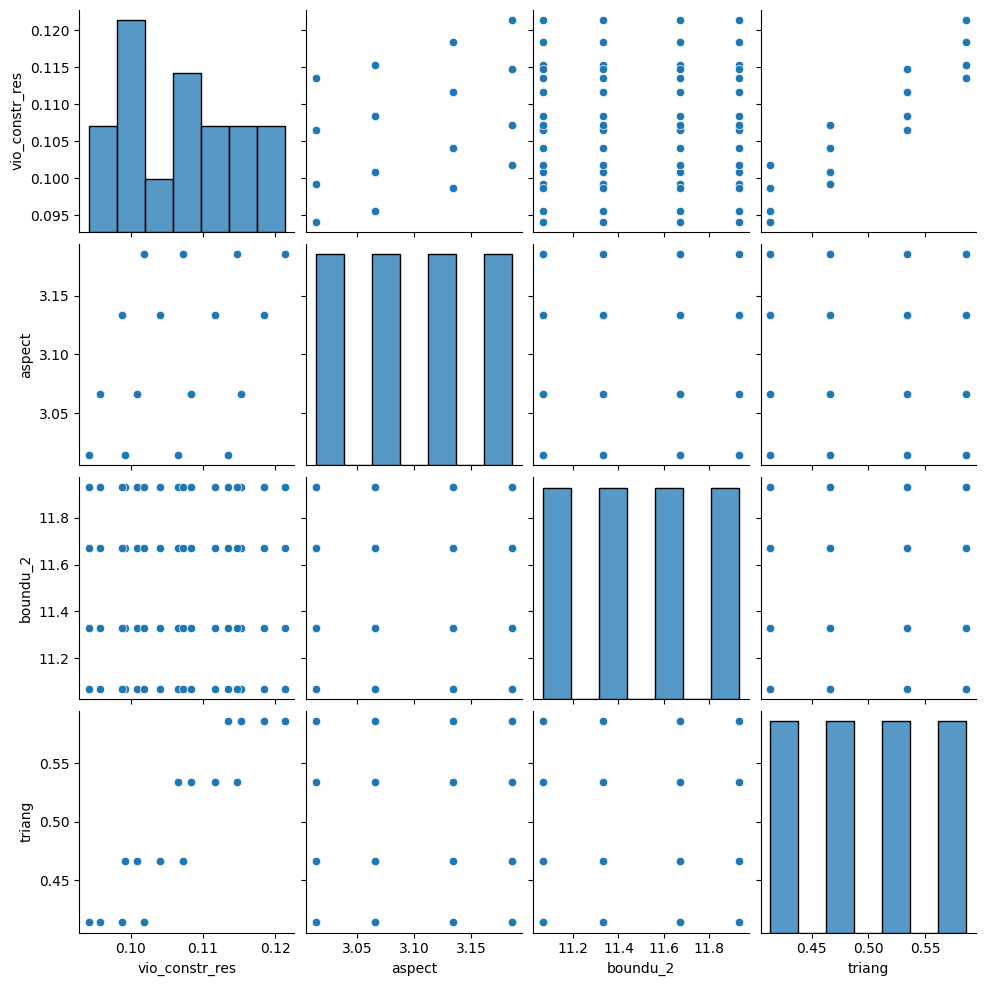

In [34]:
# Input epistemic uncertainties
# plot_list = list(vary.keys())

# vio_constr_res is output
plot_list = ["vio_constr_res", "aspect", "boundu_2", "triang"]
sub_df = results.samples[plot_list]
# pairplot doesn't support MultiIndexed columns
sub_df.columns = sub_df.columns.droplevel(1)
sns.pairplot(sub_df, kind="scatter", diag_kind="hist")

# Attempting to plot entire results df (39 columns) takes >2 mins

This is just plotting samples, and isn't taking advantage of the analysis in EasyVVUQ. However, it's a good visualisation.

## Sobol indices

Can we get Sobol information out of this?

/home/jon/anaconda3/envs/feasibility-uq/lib/python3.10/site-packages/easyvvuq/analysis/results.py:417: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


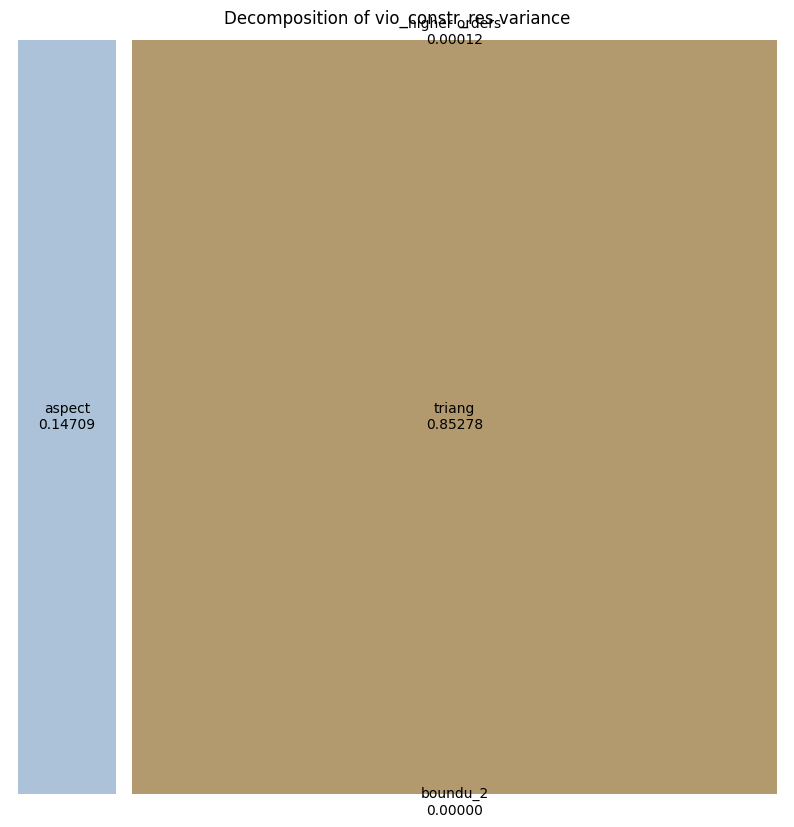

In [39]:
# results.plot_moments(qoi="vio_constr_res")
# results.plot_sobols_first("vio_constr_res") # only for vecotr qois. Like constraint vectors?

# Div by zero bug goes away when using more uncertainties
results.plot_sobols_treemap("vio_constr_res", figsize=(10, 10))